In [ ]:
pip install mesa

In [ ]:

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

def compute_infection(model):
    agent_healths = [agent.healthStat for agent in model.schedule.agents]
    infected_count = agent_healths.count("Infected")
    return infected_count

class RiderAgent(Agent):
    """ An agent with ID, Source, Destination, RequestTimeHour & HealthStat."""
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
       # self.source = random.randint(1,2501)
        self.destination = random.randint(1,2501)
        self.requestTime = random.randint(0,23)
        self.healthStat = 'Healthy' #getRiderHealthState()
        self.gridHealthStat = 'Safe' #getGridHealthState()
        self.rideApproved = -1

    def getRiderHealthState(self):
           health_state = ['Suspectible', 'Infected', 'Recovered', 'Healthy' ]
           return random.choices(health_state, weights=(20,20,10,50),k=1)[0]

    def getGridHealthState(self):
          grid_health_state = ['Safe', 'Unsafe']
          return random.choices(grid_health_state, weights=(80,20),k=1)[0]

    def getRideApproval(self):
        if self.healthStat=='Healthy':
          if self.gridHealthStat == 'Safe':
              return 0

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        self.healthStat = self.getRiderHealthState()
        #print ("Hi, I am rider " + str(self.unique_id))
        #print(vars(self)) 

        ## Get Deatination grid from Mobility Controller
        #self.destination = random.randint(1,2501)

        ## Get Health Stat for destination grid from Epidemiological Model
        self.gridHealthStat = self.getGridHealthState()

        ## Get the ride approved from controller
        self.rideApproved = self.getRideApproval()
        
        if self.rideApproved == 0:
          y = self.destination // 50
          #y -= 1
          x = self.destination % 50
          newPos = x,y
          #newPos = self.destination
          self.model.grid.move_agent(self, newPos)
        ## Get Health Stat for rider from Epidemiological Model
        self.healthStat = self.getRiderHealthState()
        #print ("Hi, I am rider " + str(self.unique_id))
        #pprint(vars(self)) 

class RiderModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = RiderAgent(i, self)
            self.schedule.add(a)

             # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Infection": compute_infection},
            agent_reporters={"Health": "healthStat"})

    def step(self):
        '''Advance the model by one step.'''
        self.datacollector.collect(self)
        self.schedule.step()


In [ ]:
model = RiderModel(1000, 50, 50)
for i in range(100):
  model.step()


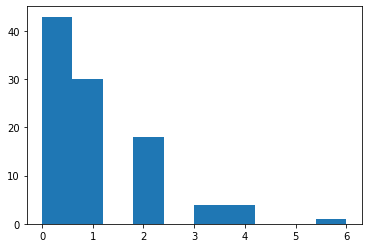

In [ ]:
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

# For jupyter notebook add the following line:
%matplotlib inline

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)
#For a script add the following line
plt.show()

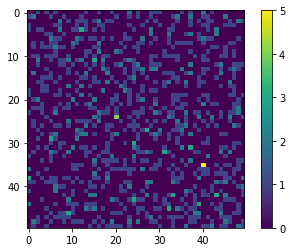

In [ ]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [ ]:
agent_health = model.datacollector.get_agent_vars_dataframe()
agent_health.head()

Health
Step AgentID         
0    0        Healthy
     1        Healthy
     2        Healthy
     3        Healthy
     4        Healthy

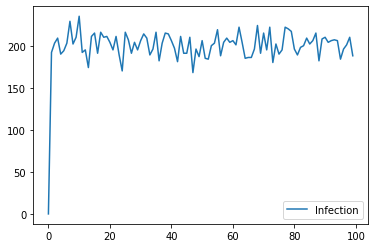

In [ ]:
infection = model.datacollector.get_model_vars_dataframe()
infection.plot()